

---
# Import Necessary Libraries
---



In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import kstest, anderson, genpareto, t
from pyextremes import EVA, plot_mean_residual_life, plot_parameter_stability
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

---
# Download SBIN, INFY data using yfinance
---

In [3]:
# Download data
tickers = ["SBIN.NS", "INFY.NS"]
data = yf.download(tickers, group_by="ticker", period="max")

# Select only 'Close'
close = data.xs('Close', axis=1, level=1).dropna()

# Compute daily log returns in %
returns = np.log(close/close.shift(1)).dropna() * 100

print("\nLog Returns of SBIN, INFY over time:\n")
display(returns.head(3))

[*********************100%***********************]  2 of 2 completed


Log Returns of SBIN, INFY over time:



Ticker,SBIN.NS,INFY.NS
Date,,
1996-01-02,-3.234693,-0.405248
1996-01-03,-2.702515,0.674609
1996-01-04,-0.346323,-0.662360


---
# Plot Log Returns
---

In [4]:
def plot_returns(log_returns, stock_symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(log_returns.index, log_returns, label=f'{stock_symbol}_Log_Returns')
    plt.title('Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

### Plot SBIN Log Returns

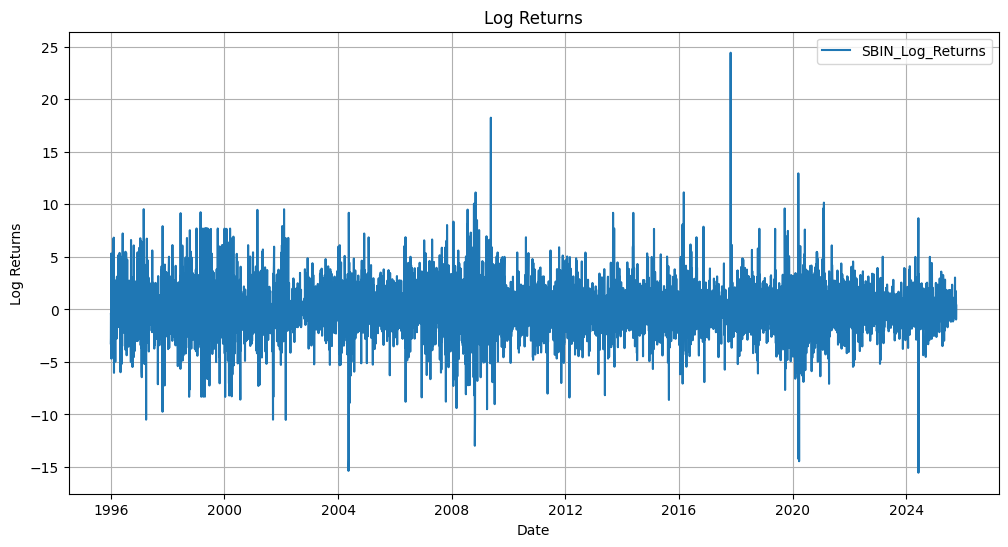

In [5]:
# Plot Log Returns of SBIN.NS
plot_returns(returns["SBIN.NS"], 'SBIN')

### Plot INFY Log Returns

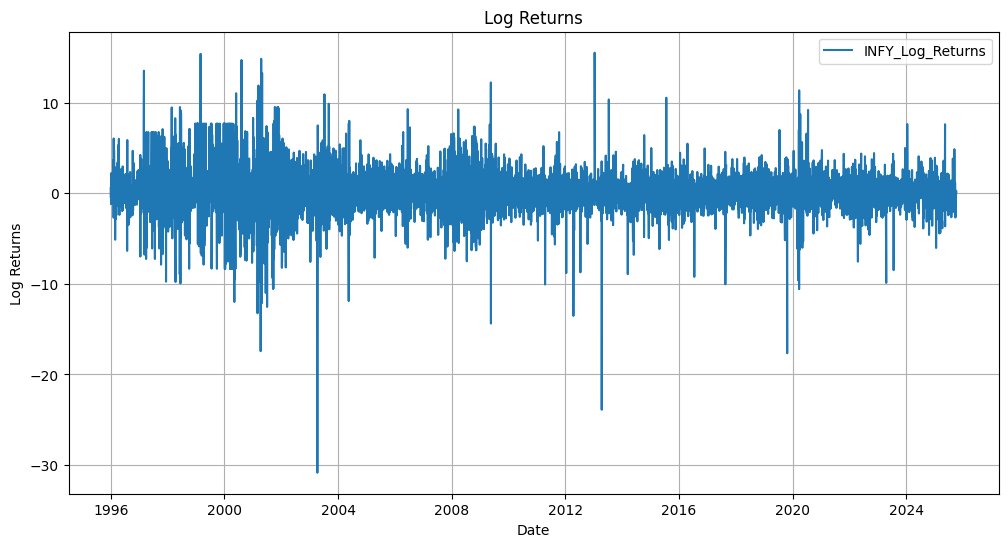

In [6]:
# Plot Log Returns of INFY.NS
plot_returns(returns["INFY.NS"], 'INFY')

---
# Train, Test split Data
---


In [7]:
def train_test_split(data, train_percentage=0.95):
    # Perform train-test split
    train_size = int(len(data) * train_percentage)
    train, test = data[0:train_size], data[train_size:]
    print('Train data shape:', train.shape)
    print('Test data shape:', test.shape)
    return train, test

---
# Fit the AR-GJR-GARCH-StudentsT model on Data
---

In [8]:
def gjr_garch_result(train, lags=10):
  model = arch_model(
        train,
        mean='AR',           # AR model for mean
        lags=lags,           # AR(lags)
        vol='GARCH',         # Volatility model
        p=1,                 # GARCH order
        o=1,                 # GJR (leverage) order
        q=1,                 # GARCH lag order
        dist='t'             # Student's t distribution
    )
  # Fit the model
  result = model.fit(disp='off')

  # Get AIC and BIC
  aic = result.aic
  bic = result.bic
  print(f"AIC: {aic:.4f}")
  print(f"BIC: {bic:.4f}")

  return result


---
#  Ljung-Box test on ε and ε² and ARCH-LM Test
---

In [9]:
def garch_diagnostics(result, lags=20):
  # Standardized residuals
  std_resid = result.std_resid.dropna()

  print("\nLjung-Box Test on Residuals:")
  lb_resid = acorr_ljungbox(std_resid, lags=[lags], return_df=True)
  print(lb_resid)

  print("\nLjung-Box Test on Squared Residuals:")
  lb_resid2 = acorr_ljungbox(std_resid**2, lags=[lags], return_df=True)
  print(lb_resid2)

  print("\nARCH LM Test:")
  lm_test = het_arch(std_resid, nlags=lags)
  print(f"LM stat: {lm_test[0]:.4f}, p-value: {lm_test[1]:.4f}")
  return std_resid


---
### Fit: AR-GJR-GARCH-StudentsT on SBIN and INFY with AIC/BIC
### Post Fit: Ljung-Box test on ε and ε², ARCH-LM Test on both data
---

In [10]:
std_resids = {}
for ticker in tickers:
    print("\n" + "="*40)
    print(f"{ticker}: AR–GJR–GARCH(1,1) with Student-t")

    train, test = train_test_split(returns[ticker])
    result = gjr_garch_result(train)

    print("\nDiagnostics for", ticker)
    std_resid = garch_diagnostics(result)
    print("\n" + "="*40)
    std_resids[ticker]= std_resid


SBIN.NS: AR–GJR–GARCH(1,1) with Student-t
Train data shape: (7097,)
Test data shape: (374,)
AIC: 30744.0776
BIC: 30853.9339

Diagnostics for SBIN.NS

Ljung-Box Test on Residuals:
      lb_stat  lb_pvalue
20  22.687343   0.304406

Ljung-Box Test on Squared Residuals:
      lb_stat  lb_pvalue
20  14.448664   0.807039

ARCH LM Test:
LM stat: 14.6876, p-value: 0.7940


INFY.NS: AR–GJR–GARCH(1,1) with Student-t
Train data shape: (7097,)
Test data shape: (374,)
AIC: 29512.4141
BIC: 29622.2704

Diagnostics for INFY.NS

Ljung-Box Test on Residuals:
      lb_stat  lb_pvalue
20  26.932592   0.137171

Ljung-Box Test on Squared Residuals:
      lb_stat  lb_pvalue
20  11.661945    0.92722

ARCH LM Test:
LM stat: 12.6430, p-value: 0.8922



---
# Plot Mean Residual Life & Parameter Stability
---


Extreme Value Analysis for SBIN.NS


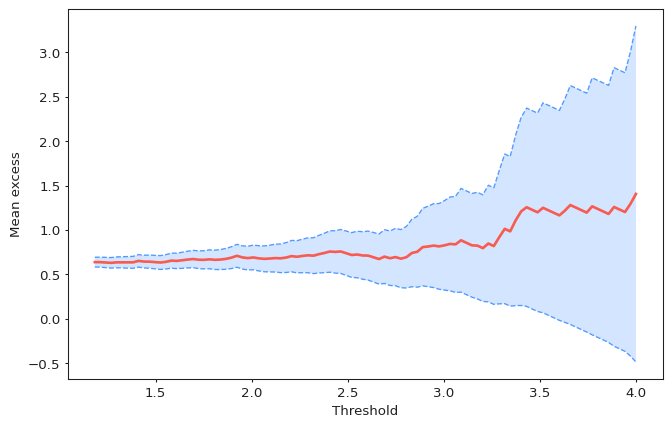

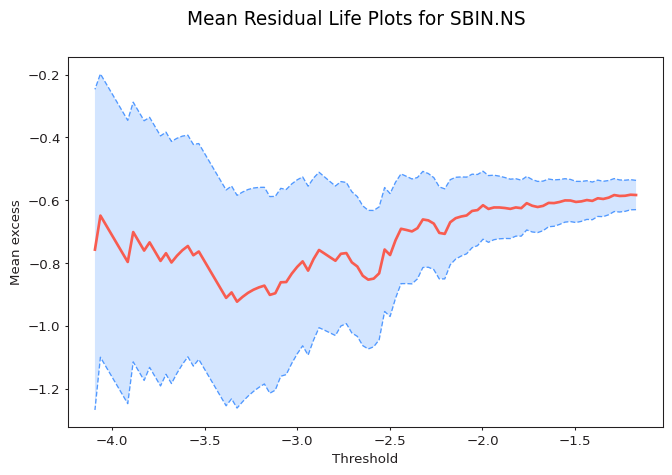

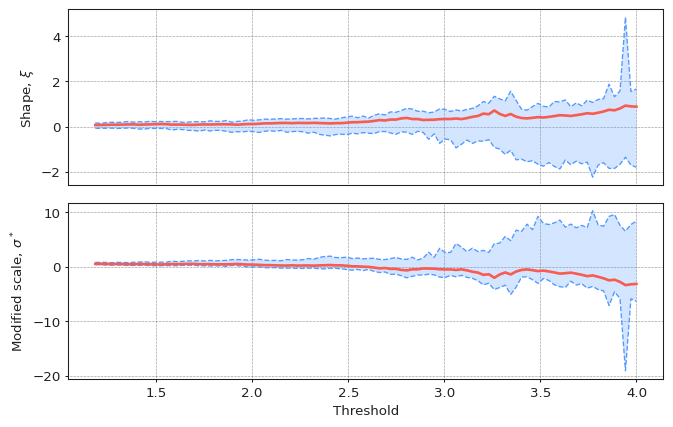

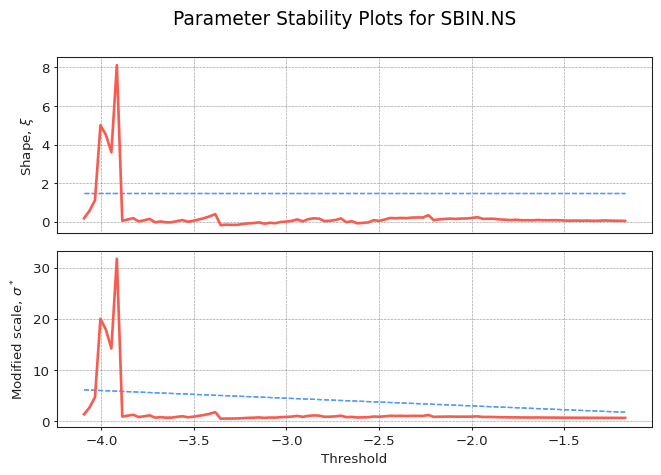


Extreme Value Analysis for INFY.NS


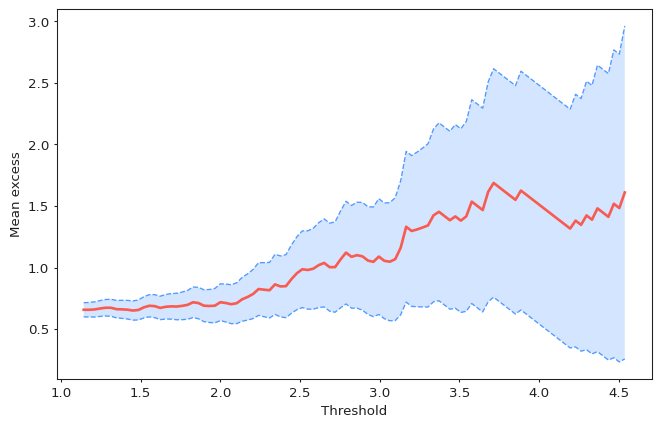

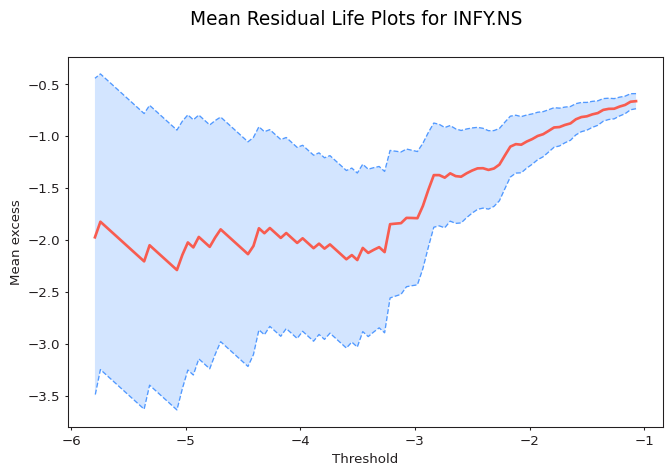

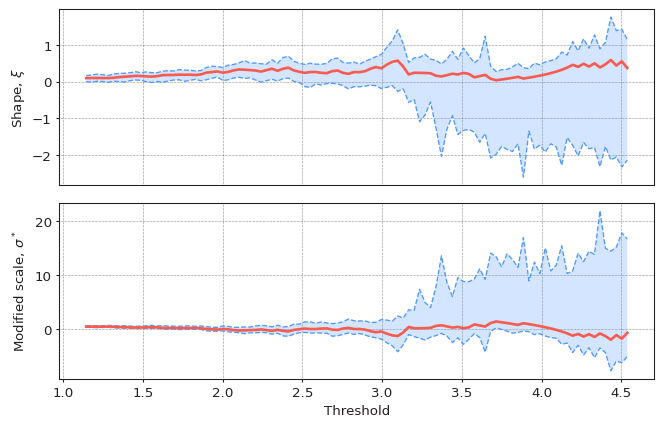

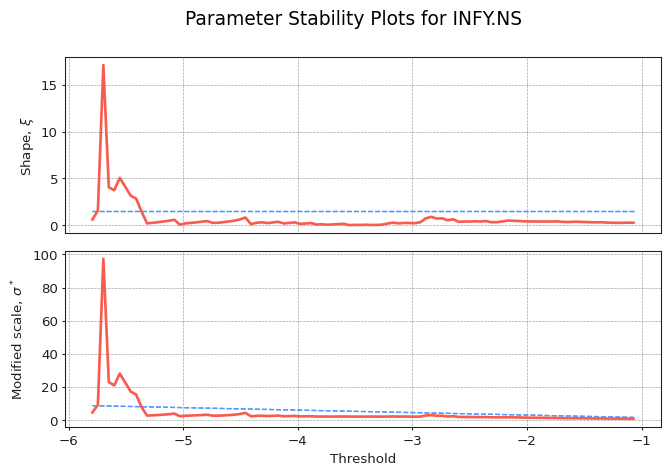

In [ ]:
for ticker, std_resid in std_resids.items():
    print("\n" + "="*34)
    print(f"Extreme Value Analysis for {ticker}")

    # Fit EVA model
    model = EVA(std_resid)

    # Plot Mean Residual Life
    plot_mean_residual_life(std_resid, alpha=0.95, extremes_type='high')
    plot_mean_residual_life(std_resid, alpha=0.95, extremes_type='low')
    plt.suptitle(f"Mean Residual Life Plots for {ticker}", fontsize=14)
    plt.show()

    # Plot Parameter Stability
    plot_parameter_stability(std_resid, alpha=0.95, extremes_type='high')
    plot_parameter_stability(std_resid, alpha=0.95, extremes_type='low')
    plt.suptitle(f"Parameter Stability Plots for {ticker}", fontsize=14)
    plt.show()

    print("="*34)

---
# Threshold Selection
---

### Select Threshold for SBIN

In [11]:
# Find Best threshold (quantile) so that p value > 0.05
def select_threshold(r, q_range, min_exceedances=100, tail="upper"):
    results = []
    r = np.asarray(r)

    for q in q_range:
        thr = np.quantile(r, q)

        if tail == "upper":
            exceedances = r[r > thr] - thr
        elif tail == "lower":
            exceedances = thr - r[r < thr]
        else:
            raise ValueError("tail must be 'upper' or 'lower'")

        n_exc = len(exceedances)
        if n_exc < min_exceedances:
            continue

        shape, loc, scale = genpareto.fit(exceedances, floc=0)

        ks_stat, ks_p = kstest(exceedances, "genpareto", args=(shape, 0, scale))
        u = genpareto.cdf(exceedances, c=shape, loc=0, scale=scale)
        u = np.clip(u, 1e-12, 1 - 1e-12)
        exp_data = -np.log(u)
        ad_res = anderson(exp_data, dist="expon")
        ad_stat = ad_res.statistic

        results.append({
            "quantile": q,
            "threshold": thr,
            "n_exc": n_exc,
            "shape": shape,
            "scale": scale,
            "ks_stat": ks_stat,
            "ks_p": ks_p,
            "ad_stat": ad_stat
        })

    results = sorted(results, key=lambda x: -x["ks_p"])
    return results

---
### Upper Threshold , corrosponding KS-P value, AD Statistics for SBIN
---

In [12]:
upper_results = select_threshold(std_resids["SBIN.NS"], q_range=np.arange(0.92, 0.981, 0.005), tail="upper")
upper_best = upper_results[9] # i=9
print("Upper Best threshold selection:")
print(f"Quantile: {upper_best['quantile']:.3f}, Threshold: {upper_best['threshold']:.4f}")
print(f"Exceedances: {upper_best['n_exc']}, Shape: {upper_best['shape']:.4f}, Scale: {upper_best['scale']:.4f}")
print(f"KS p={upper_best['ks_p']:.4f}, AD stat={upper_best['ad_stat']:.4f}")
print()

Upper Best threshold selection:
Quantile: 0.970, Threshold: 1.9050
Exceedances: 213, Shape: 0.1058, Scale: 0.6206
KS p=0.5947, AD stat=0.6661



---
### Lower Threshold , corrosponding KS-P value, AD Statistics for SBIN
---

In [13]:
lower_results = select_threshold(std_resids["SBIN.NS"], q_range=np.arange(0.02, 0.081, 0.005), tail="lower")
lower_best = lower_results[9] # j=9
print("Best lower threshold selection:")
print(f"Quantile: {lower_best['quantile']:.3f}, Threshold: {lower_best['threshold']:.4f}")
print(f"Exceedances: {lower_best['n_exc']}, Shape: {lower_best['shape']:.4f}, Scale: {lower_best['scale']:.4f}")
print(f"KS p={lower_best['ks_p']:.4f}, AD stat={lower_best['ad_stat']:.4f}")


Best lower threshold selection:
Quantile: 0.025, Threshold: -1.9664
Exceedances: 178, Shape: 0.1533, Scale: 0.5307
KS p=0.7756, AD stat=0.4125


---
# Smooth CDF, t-Body and GPD tail with Logistics splice for SBIN
---

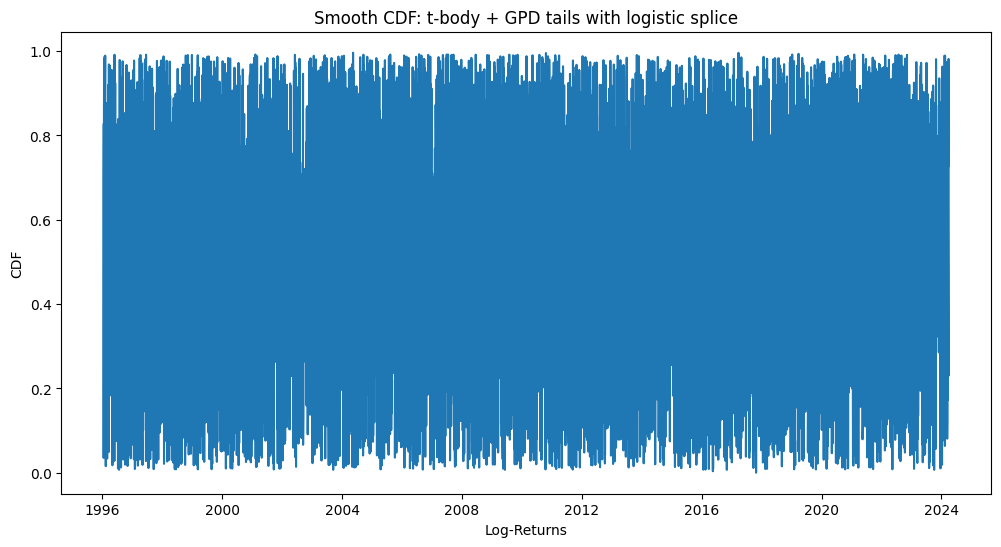

In [14]:
r=std_resids["SBIN.NS"]
upper_threshold = upper_best['threshold']
shape_upper = upper_best['shape']
scale_upper = upper_best['scale']
lower_threshold = lower_best['threshold']
shape_lower = lower_best['shape']
scale_lower = lower_best['scale']

# Small transition width
k = 0.001 * (upper_threshold - lower_threshold)

# Fit body (t-distribution)
df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

# Logistic splice
def logistic_splice(x, x0, k):
    return 1 / (1 + np.exp(-(x-x0)/k))

# Smooth CDF
def smooth_cdf(x):
    F = np.zeros_like(x, dtype=float)

    # Lower tail
    mask_lower = x <= lower_threshold
    F[mask_lower] = (1 - logistic_splice(x[mask_lower], lower_threshold, k)) * genpareto.cdf(lower_threshold - x[mask_lower], shape_lower, 0, scale_lower) \
                + logistic_splice(x[mask_lower], lower_threshold, k) * t.cdf(x[mask_lower], df_body, loc_body, scale_body)

    # Body
    mask_body = (x > lower_threshold) & (x < upper_threshold)
    F[mask_body] = t.cdf(x[mask_body], df_body, loc_body, scale_body)

    # Upper tail
    mask_upper = x >= upper_threshold
    F[mask_upper] = (1 - logistic_splice(x[mask_upper], upper_threshold, k)) * t.cdf(x[mask_upper], df_body, loc_body, scale_body) \
                + logistic_splice(x[mask_upper], upper_threshold, k) * (1 - genpareto.cdf(x[mask_upper] - upper_threshold, shape_upper, 0, scale_upper))

    return F

# Plot
plt.figure(figsize=(12, 6))
plt.plot(r.index, smooth_cdf(r))
plt.xlabel("Log-Returns")
plt.ylabel("CDF")
plt.title("Smooth CDF: t-body + GPD tails with logistic splice")
plt.show()


---
### PIT  Histogram for SBIN
---

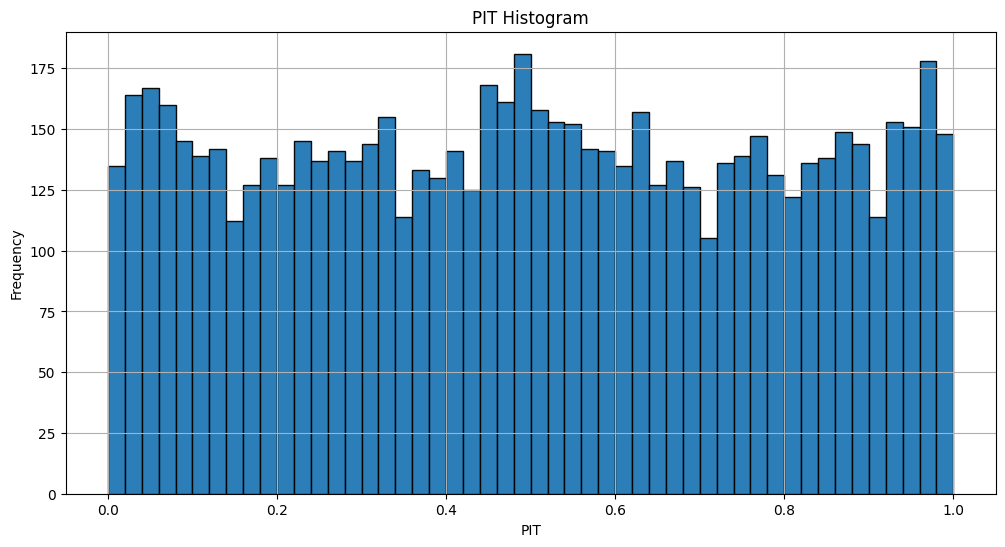

In [15]:
pit_values = smooth_cdf(r)
plt.figure(figsize=(12,6))
plt.hist(pit_values, bins=50, range=(0,1), edgecolor='k', alpha=0.95)
plt.xlabel("PIT")
plt.ylabel("Frequency")
plt.title("PIT Histogram")
plt.grid(True)
plt.show()

In [16]:
ks_stat, p_value = kstest(pit_values, 'uniform')
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.0116, p-value: 0.2976


---
### Find the i, j th threshold among all thresholds (p-value > 0.05) such that Globel PIT pass KS for SBIN
---

In [ ]:
# Search best (i, j) combination
best_result = None
best_p = -1

for i in range(len(upper_results)):
    for j in range(len(lower_results)):
        upper_best = upper_results[i]
        lower_best = lower_results[j]

        upper_threshold = upper_best['threshold']
        shape_upper = upper_best['shape']
        scale_upper = upper_best['scale']

        lower_threshold = lower_best['threshold']
        shape_lower = lower_best['shape']
        scale_lower = lower_best['scale']

        # Small transition width
        k = 0.001 * (upper_threshold - lower_threshold)

        # Fit body (t-distribution)
        df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

        # Smooth CDF using your definition
        pit_values = smooth_cdf(r)

        ks_stat, p_value = kstest(pit_values, 'uniform')

        if p_value > best_p:  # track maximum p-value
            best_p = p_value
            best_result = (i, j, ks_stat, p_value, upper_best, lower_best)

print("Best combination found:")
print(f"i={best_result[0]}, j={best_result[1]}")
print(f"KS stat={best_result[2]:.4f}, p-value={best_result[3]:.4f}")
print("Upper best:", best_result[4])
print("Lower best:", best_result[5])


Best combination found:
i=9, j=9
KS stat=0.0116, p-value=0.2976
Upper best: {'quantile': np.float64(0.9700000000000001), 'threshold': np.float64(1.9050157023268544), 'n_exc': 213, 'shape': np.float64(0.10583775293521605), 'scale': np.float64(0.6206625458960544), 'ks_stat': np.float64(0.05193958926962258), 'ks_p': np.float64(0.5950780502558274), 'ad_stat': np.float64(0.6677043190278766)}
Lower best: {'quantile': np.float64(0.025), 'threshold': np.float64(-1.9664385565639861), 'n_exc': 178, 'shape': np.float64(0.15332396205722604), 'scale': np.float64(0.5307529987193547), 'ks_stat': np.float64(0.04861921252577628), 'ks_p': np.float64(0.7753467492140156), 'ad_stat': np.float64(0.41276190092060006)}


---
### Select Threshold for INFY
### Upper Threshold , corrosponding KS-P value, AD Statistics for INFY
---

In [22]:
r = std_resids["INFY.NS"]
upper_results = select_threshold(r, q_range=np.arange(0.92, 0.981, 0.005), tail="upper")
upper_best = upper_results[2] # i=2
print("Upper Best threshold selection:")
print(f"Quantile: {upper_best['quantile']:.3f}, Threshold: {upper_best['threshold']:.4f}")
print(f"Exceedances: {upper_best['n_exc']}, Shape: {upper_best['shape']:.4f}, Scale: {upper_best['scale']:.4f}")
print(f"KS p={upper_best['ks_p']:.4f}, AD stat={upper_best['ad_stat']:.4f}")
print()

Upper Best threshold selection:
Quantile: 0.935, Threshold: 1.4235
Exceedances: 461, Shape: 0.1432, Scale: 0.5641
KS p=0.6600, AD stat=0.8893



---
### Lower Threshold, corrosponding KS-P value, AD Statistics for INFY
---

In [23]:
lower_results = select_threshold(r, q_range=np.arange(0.02, 0.081, 0.005), tail="lower")
lower_best = lower_results[1] #j=1
print("Best lower threshold selection:")
print(f"Quantile: {lower_best['quantile']:.3f}, Threshold: {lower_best['threshold']:.4f}")
print(f"Exceedances: {lower_best['n_exc']}, Shape: {lower_best['shape']:.4f}, Scale: {lower_best['scale']:.4f}")
print(f"KS p={lower_best['ks_p']:.4f}, AD stat={lower_best['ad_stat']:.4f}")


Best lower threshold selection:
Quantile: 0.040, Threshold: -1.5829
Exceedances: 284, Shape: 0.3542, Scale: 0.5462
KS p=0.9626, AD stat=0.2552


---
## Smooth CDF, t-Body and GPD tail with Logistics splice for INFY
---

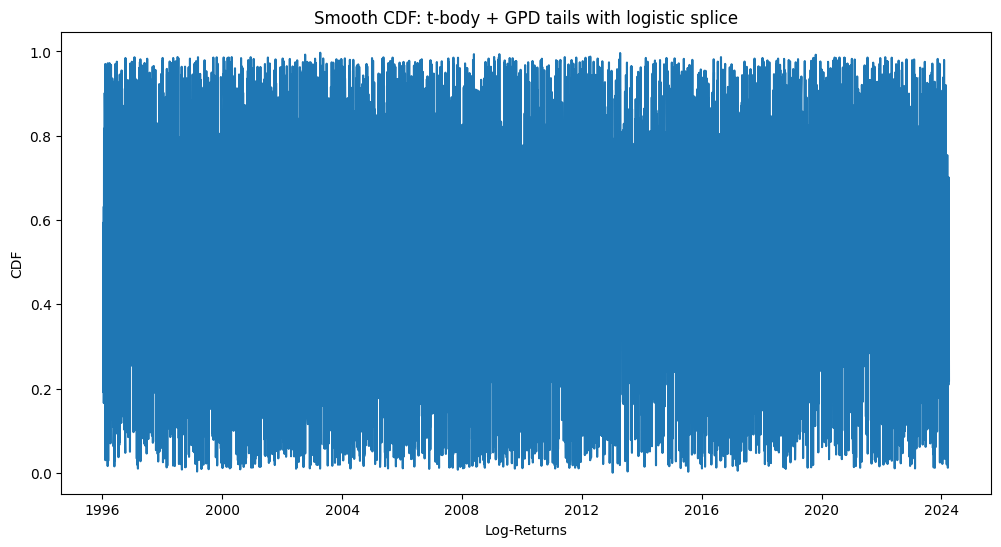

In [24]:
upper_threshold = upper_best['threshold']
shape_upper = upper_best['shape']
scale_upper = upper_best['scale']
lower_threshold = lower_best['threshold']
shape_lower = lower_best['shape']
scale_lower = lower_best['scale']

# Small transition width
k = 0.001 * (upper_threshold - lower_threshold)

# Fit body (t-distribution)
df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(r.index, smooth_cdf(r))
plt.xlabel("Log-Returns")
plt.ylabel("CDF")
plt.title("Smooth CDF: t-body + GPD tails with logistic splice")
plt.show()


---
### PIT  Histogram for INFY
---

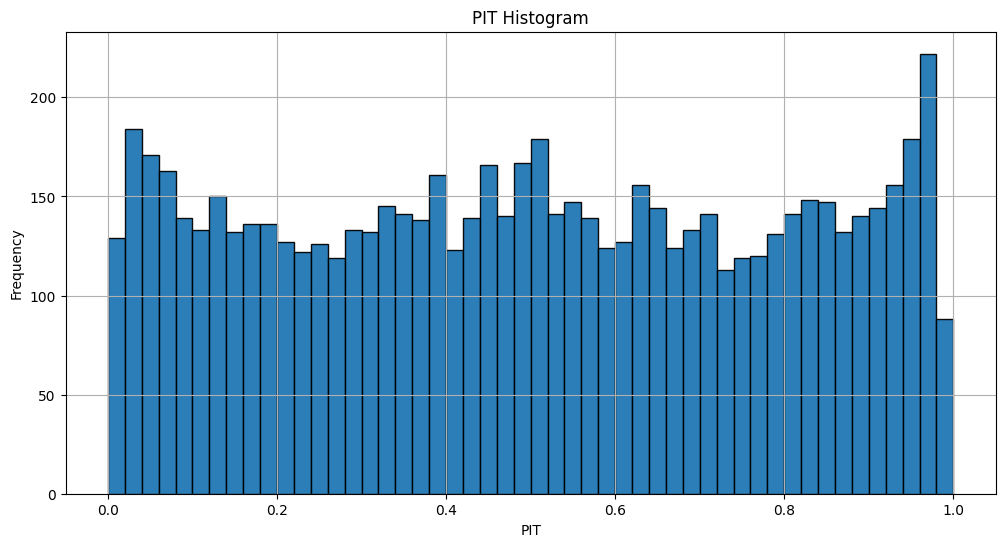

In [25]:
pit_values = smooth_cdf(r)
plt.figure(figsize=(12,6))
plt.hist(pit_values, bins=50, range=(0,1), edgecolor='k', alpha=0.95)
plt.xlabel("PIT")
plt.ylabel("Frequency")
plt.title("PIT Histogram")
plt.grid(True)
plt.show()

---
### Ks Test
---

In [26]:
ks_stat, p_value = kstest(pit_values, 'uniform')

print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.0125, p-value: 0.2192


---
## Find the i, j th threshold among all thresholds (p-value > 0.05) such that Globel PIT pass KS for INFY
---

In [ ]:
# Search best (i, j) combination
best_result = None
best_p = -1

for i in range(len(upper_results)):
    for j in range(len(lower_results)):
        upper_best = upper_results[i]
        lower_best = lower_results[j]

        upper_threshold = upper_best['threshold']
        shape_upper = upper_best['shape']
        scale_upper = upper_best['scale']

        lower_threshold = lower_best['threshold']
        shape_lower = lower_best['shape']
        scale_lower = lower_best['scale']

        # Small transition width
        k = 0.001 * (upper_threshold - lower_threshold)

        # Fit body (t-distribution)
        df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

        # Smooth CDF using your definition
        pit_values = smooth_cdf(r)

        ks_stat, p_value = kstest(pit_values, 'uniform')

        if p_value > best_p:  # track maximum p-value
            best_p = p_value
            best_result = (i, j, ks_stat, p_value, upper_best, lower_best)

print("Best combination found:")
print(f"i={best_result[0]}, j={best_result[1]}")
print(f"KS stat={best_result[2]:.4f}, p-value={best_result[3]:.4f}")
print("Upper best:/n", best_result[4])
print("Lower best:/n", best_result[5])


Best combination found:
i=2, j=1
KS stat=0.0125, p-value=0.2197
Upper best:/n {'quantile': np.float64(0.935), 'threshold': np.float64(1.423450740027489), 'n_exc': 461, 'shape': np.float64(0.1432416701990069), 'scale': np.float64(0.5640021874344572), 'ks_stat': np.float64(0.03369916089719316), 'ks_p': np.float64(0.6589501803589439), 'ad_stat': np.float64(0.8891027981698016)}
Lower best:/n {'quantile': np.float64(0.04000000000000001), 'threshold': np.float64(-1.5829345663076653), 'n_exc': 284, 'shape': np.float64(0.35432760543835273), 'scale': np.float64(0.5462197065207943), 'ks_stat': np.float64(0.029260052498399025), 'ks_p': np.float64(0.9623024224755616), 'ad_stat': np.float64(0.2553740473541666)}


## Summary Table for SBIN.NS

| Metric               | Value                                                 |
|----------------------|-------------------------------------------------------|
| Model                | AR-GJR-GARCH-StudentsT + Composite (t-body + GPD tails) |
| LB (ε) p-value       | 0.3044                                                |
| LB (ε²) p-value      | 0.8070                                                |
| ARCH-LM p-value      | 0.7940                                                |
| Upper Threshold      | 1.9050                                                |
| Upper Exceedances    | 213                                                   |
| GPD Upper ξ          | 0.1058                                      |
| GPD Upper β          | 0.6207                                      |
| Lower Threshold      | -1.9664                                               |
| Lower Exceedances    | 178                                                   |
| GPD Lower ξ          | 0.1533                                      |
| GPD Lower β          | 0.5308                                      |
| PIT KS p-value       | 0.2976                                                |

## Summary Table for INFY.NS

| Metric               | Value                                                 |
|----------------------|-------------------------------------------------------|
| Model                | AR-GJR-GARCH-StudentsT + Composite (t-body + GPD tails) |
| LB (ε) p-value       | 0.1372                                                |
| LB (ε²) p-value      | 0.9272                                                |
| ARCH-LM p-value      | 0.8921                                                |
| Upper Threshold      | 1.4235                                                |
| Upper Exceedances    | 461                                                   |
| GPD Upper ξ          | 0.1432                                      |
| GPD Upper β          | 0.5640                                      |
| Lower Threshold      | -1.5829                                               |
| Lower Exceedances    | 284                                                   |
| GPD Lower ξ          | 0.3543                                      |
| GPD Lower β          | 0.5462                                      |
| PIT KS p-value       | 0.2197                                                |